In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
csv_path = os.path.join('..','datasets','raw','data.csv')
df = pd.read_csv(csv_path)
df.sample(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
6881,Lincoln,MKX,2016,regular unleaded,303.0,6.0,AUTOMATIC,front wheel drive,4.0,"Crossover,Luxury",Midsize,4dr SUV,26,17,61,53475
5738,Toyota,Highlander,2015,regular unleaded,270.0,6.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,4dr SUV,25,19,2031,36590
845,Saab,9-3,2011,premium unleaded (recommended),210.0,4.0,MANUAL,front wheel drive,4.0,Luxury,Midsize,Sedan,31,21,376,28900
1233,Honda,Accord,2016,regular unleaded,278.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,34,21,2202,32745
4414,Mitsubishi,Expo,1993,regular unleaded,136.0,4.0,MANUAL,front wheel drive,2.0,Hatchback,Compact,2dr Hatchback,26,19,436,2000
4441,Chevrolet,Express,2016,flex-fuel (unleaded/E85),285.0,8.0,AUTOMATIC,rear wheel drive,3.0,Flex Fuel,Large,Passenger Van,16,11,1385,37500
11533,BMW,X6,2017,premium unleaded (required),445.0,8.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Luxury,Performance",Midsize,4dr SUV,21,15,3916,76100
3324,Oldsmobile,Cutlass Ciera,1994,regular unleaded,160.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Wagon,26,17,26,2000
10650,Ford,Transit Connect,2015,regular unleaded,169.0,4.0,AUTOMATIC,front wheel drive,4.0,NaN,Compact,Cargo Minivan,29,21,5657,22330
6320,Mitsubishi,Lancer Evolution,2015,premium unleaded (required),303.0,4.0,MANUAL,all wheel drive,4.0,"Factory Tuner,High-Performance",Compact,Sedan,23,17,436,37995


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [4]:
my_variables = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
cars = df[my_variables].copy()

# Lowercase the column names and replace spaces with underscores
cars.columns = cars.columns.str.lower().str.replace(' ','_')
categorical_columns = list(cars.dtypes[cars.dtypes == 'object'].index)

for c in categorical_columns:
    cars[c] = cars[c].str.lower().str.replace(' ', '_')
    
cars.sample(5)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
570,fiat,500l,2015,160.0,4.0,manual,wagon,33,25,19345
11618,volvo,xc70,2016,250.0,5.0,automatic,wagon,26,19,38600
11800,subaru,xv_crosstrek,2014,148.0,4.0,automatic,4dr_suv,33,25,22995
4605,ford,f-250,1997,220.0,8.0,manual,extended_cab_pickup,17,12,2836
11098,aston_martin,v12_vantage_s,2016,565.0,12.0,automated_manual,coupe,18,12,183695


In [5]:
# Lowercase the column names and replace spaces with underscores
cars.columns = cars.columns.str.lower().str.replace(' ','_')

In [6]:
# View missing values
cars.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [7]:
# FIll the missing values with 0
cars[['engine_hp','engine_cylinders']] = cars[['engine_hp','engine_cylinders']].fillna(value=0)

In [8]:
msrp_mean = cars['msrp'].mean()
bin_msrp = [0, msrp_mean, float('inf')]
cars['above_average'] = pd.cut(cars['msrp'], bins=bin_msrp, labels=[1,0])
cars['above_average']

0        0
1        0
2        1
3        1
4        1
        ..
11909    0
11910    0
11911    0
11912    0
11913    1
Name: above_average, Length: 11914, dtype: category
Categories (2, int64): [1 < 0]

In [9]:
#features = cars.drop('msrp', axis=1).copy()
#target = cars['msrp'].copy()

df_full_train, df_test = train_test_split(cars, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

df_train.shape[0], df_test.shape[0], df_val.shape[0]

(7148, 2383, 2383)

In [12]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

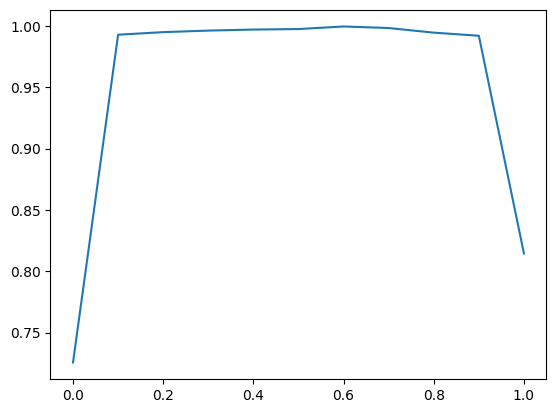

In [13]:
thresholds = np.linspace(0, 1, 11)

accuracies = []
for t in thresholds:
    prob = y_pred >= t
    acc = accuracy_score(y_val, prob >= t)
    accuracies.append(acc)
    

plt.plot(thresholds, accuracies)